# Applications of `feature-encoders`

In this section, we present two applications: 


* one for a simple linear regression model, and 

* one for a grouped linear regression model (a model that construct one estimator per data group, splits data by values of a single column and fits one estimator per group).  

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
from feature_encoders.utils import load_config
from feature_encoders.generate import DatetimeFeatures
from feature_encoders.encode import CategoricalEncoder, SplineEncoder, ICatSplineEncoder
from feature_encoders.compose import ModelStructure
from feature_encoders.models import LinearPredictor, GroupedPredictor

In [3]:
def cvrmse(y_true, y_pred):
    resid = y_true - y_pred
    return float(np.sqrt((resid ** 2).sum() / len(resid)) / np.mean(y_true))


def nmbe(y_true, y_pred):
    resid = y_true - y_pred
    return float(np.mean(resid) / np.mean(y_true))

## Load demo data

The data consists of the energy consumption of a building and the outdoor air temperature.

In [4]:
data = pd.read_csv('data/data.csv', parse_dates=[0], index_col=0)
data = data[~data['consumption_outlier']]

X = data[['temperature']]
y = data['consumption']

## Linear regression model

The simplest model to use is a model that includes only the hour of the week as a feature. The hour of the week is a categorical feature and it can be encoded in [one-hot form](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features):

In [5]:
features = DatetimeFeatures(subset='hourofweek', remainder='drop').fit_transform(X)
dmatrix = CategoricalEncoder(feature='hourofweek', encode_as='onehot').fit_transform(features)

We can fit a linear model:

In [6]:
model = LinearRegression(fit_intercept=False).fit(dmatrix, y)

... and evaluate it in-sample:

In [7]:
pred = model.predict(dmatrix)

In [8]:
y_true = y.values

print(f"In-sample CV(RMSE) (%): {cvrmse(y_true, pred)*100}")
print(f"In-sample NMBE (%): {nmbe(y_true, pred)*100}")

In-sample CV(RMSE) (%): 19.332298975680697
In-sample NMBE (%): 7.804127359819421e-15


The degrees of freedom of the model are:

In [9]:
np.linalg.matrix_rank(dmatrix)

168

The impact of the hour of the week on energy consumption is then:

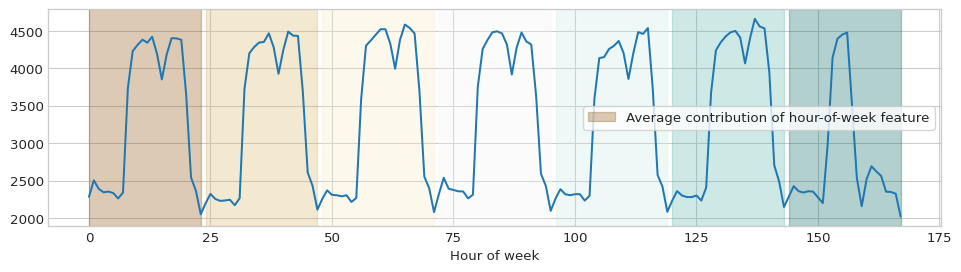

In [10]:
pred = pd.DataFrame(data=pred, index=y.index, columns=['hourofweek_impact'])

date_enc = DatetimeFeatures(remainder='passthrough', subset='hourofweek')
to_plot = date_enc.fit_transform(pred).groupby('hourofweek').mean()


colors = ['#8c510a', '#d8b365', '#f6e8c3', '#f5f5f5', '#c7eae5', '#5ab4ac', '#01665e']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    intervals = np.split(to_plot.index, 7)
    for i, item in enumerate(intervals):
        ax.axvspan(item[0], item[-1], alpha=0.3, color=colors[i])
    
    to_plot.plot(ax=ax)
    ax.set_xlabel('Hour of week')
    ax.legend(['Average contribution of hour-of-week feature'], fancybox=True, frameon=True)

We can reduce the number of categories for the hour-of-week feature while retaining as much as possible the feature's predictive capability:

In [11]:
features = DatetimeFeatures(subset='hourofweek', remainder='drop').fit_transform(X)
enc = CategoricalEncoder(feature='hourofweek', encode_as='onehot', max_n_categories=60)
dmatrix = enc.fit_transform(features, y)

In [12]:
model = LinearRegression(fit_intercept=False).fit(dmatrix, y)
pred = model.predict(dmatrix)

print(f"In-sample CV(RMSE) (%): {cvrmse(y_true, pred)*100}")
print(f"In-sample NMBE (%): {nmbe(y_true, pred)*100}")

In-sample CV(RMSE) (%): 19.34946719265366
In-sample NMBE (%): 4.263718362437927e-14


This is practically the same performance with one third of the degrees of freedom:

In [13]:
np.linalg.matrix_rank(dmatrix)

60

Another component to include in the model is an interaction term between the hour of the week and the temperature. 

The [TOWT model](https://ieeexplore.ieee.org/document/5772947/) estimates the temperature effect separately for periods of the day with high and with low energy consumption in order to distinguish between occupied and unoccupied building periods. 

To this end, a flexible curve is fitted on the `consumption~temperature` relationship, and if more than the 65% of the data points that correspond to a specific time-of-week are above the fitted curve, the corresponding hour is flagged as “Occupied”, otherwise it is flagged as “Unoccupied.” 

We can apply this approach using `feature-encoders` functionality:

In [14]:
enc = SplineEncoder(feature='temperature', degree=1, strategy='uniform').fit(X)
dmatrix = enc.transform(X)

In [15]:
model = LinearRegression(fit_intercept=False).fit(dmatrix, y)
pred = model.predict(dmatrix)
pred = pd.Series(data=pred, index=y.index)

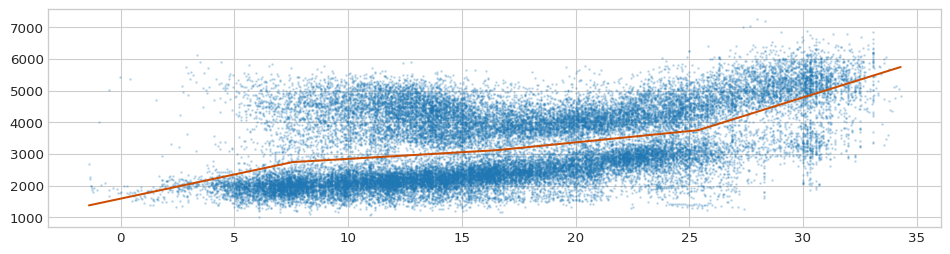

In [16]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.scatter(X['temperature'], y, s=1, alpha=0.2)
    
    X_sorted = X.sort_values(by='temperature')
    ax.plot(X_sorted, pred.loc[X_sorted.index], c='#cc4c02')

In [17]:
resid = y - pred
mask = resid > 0
mask = DatetimeFeatures(subset='hourofweek').fit_transform(mask.to_frame('freq'))
occupied = mask.groupby('hourofweek')['freq'].mean() > 0.65
occupied = occupied.to_dict()

In [18]:
features = DatetimeFeatures(subset='hourofweek').fit_transform(X)
features['occupied'] = features['hourofweek'].map(lambda x: occupied[x])
features.head()

,temperature,hourofweek,occupied
timestamp,,,
2015-12-07 12:00:00,14.300,12,True
2015-12-07 12:15:00,14.525,12,True
2015-12-07 12:30:00,14.750,12,True
2015-12-07 12:45:00,14.975,12,True
2015-12-07 13:00:00,15.200,13,True


In [19]:
enc_temp = SplineEncoder(feature='temperature', degree=1, strategy='uniform')
enc_occ = CategoricalEncoder(feature='occupied', encode_as='onehot')
enc_occ = enc_occ.fit(features) #fit before passed to the interaction

enc = ICatSplineEncoder(encoder_cat=enc_occ, encoder_num=enc_temp)
dmatrix = enc.fit_transform(features)

In [20]:
model = LinearRegression(fit_intercept=False).fit(dmatrix, y)
pred = model.predict(dmatrix)

print(f"In-sample CV(RMSE) (%): {cvrmse(y_true, pred)*100}")
print(f"In-sample NMBE (%): {nmbe(y_true, pred)*100}")

In-sample CV(RMSE) (%): 18.2731614241806
In-sample NMBE (%): 2.152083291755081e-14


In [21]:
np.linalg.matrix_rank(dmatrix)

10

Alternatively, we can rely on `feature-encoders` functionality to categorize the hours of the week into the two most dissimilar categories in terms of energy consumption given temperature information: 

In [22]:
features = DatetimeFeatures(subset='hourofweek').fit_transform(X)

enc_temp = SplineEncoder(feature='temperature', 
                         degree=1, 
                         strategy='uniform'
)
enc_occ = CategoricalEncoder(feature='hourofweek', 
                             max_n_categories=2,
                             stratify_by='temperature', 
                             min_samples_leaf=15
)
enc_occ = enc_occ.fit(features, y) #fit before passed to the interaction

enc = ICatSplineEncoder(encoder_cat=enc_occ, encoder_num=enc_temp)
dmatrix = enc.fit_transform(features)

In [23]:
model = LinearRegression(fit_intercept=False).fit(dmatrix, y)
pred = model.predict(dmatrix)

print(f"In-sample CV(RMSE) (%): {cvrmse(y_true, pred)*100}")
print(f"In-sample NMBE (%): {nmbe(y_true, pred)*100}")

In-sample CV(RMSE) (%): 17.4373587893191
In-sample NMBE (%): 8.789160508284433e-14


The prediction results are better while the number of the degrees of freedom is the same:

In [24]:
np.linalg.matrix_rank(dmatrix)

10

Then, the `consumption~temperature` curves per category of hour of week are:

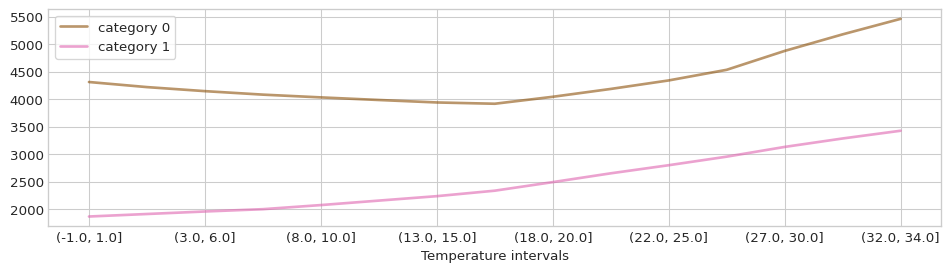

In [25]:
date_enc = DatetimeFeatures(remainder='passthrough', subset='hourofweek')

intervals = pd.concat(
    ( pd.cut(X['temperature'], 15, precision=0), 
      pd.DataFrame(data=pred, index=X.index, columns=['temperature_impact'])
    ), 
    axis=1
)

enc_cat = enc_occ.feature_pipeline_['reduce_dimension']
intervals = date_enc.fit_transform(intervals)
intervals['hourofweek'] = intervals['hourofweek'].map(lambda x: enc_cat.mapping_[x])

to_plot = (
    intervals.groupby(['hourofweek', 'temperature'])['temperature_impact']
             .mean()
             .unstack()
)

colors = ['#8c510a', '#df65b0']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    for i, (idx, values) in enumerate(to_plot.iterrows()):
        values.plot(ax=ax, lw=2, alpha=0.6, label=f'category {idx}', color=colors[i])

    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_xlabel('Temperature intervals')
    ax.legend(fancybox=True, frameon=True)

In `confing/models`, there is a YAML file (towt.yaml) that defines a linear regression model with the two components above and two additional ones:

1. A categorical feature for the different months in the dataset.
2. A linear term for the temperature as a main effect. The interaction term between temperature and the hour of the week "corrects" the predictions of the temperature's linear term in the main effects.

In [26]:
model_conf, feature_conf = load_config(model='towt', features='default')

In [27]:
print(json.dumps(model_conf, indent=4))

{
    "add_features": {
        "time": {
            "type": "datetime",
            "subset": "month, hourofweek"
        }
    },
    "regressors": {
        "month": {
            "feature": "month",
            "type": "categorical",
            "encode_as": "onehot"
        },
        "tow": {
            "feature": "hourofweek",
            "type": "categorical",
            "max_n_categories": 60,
            "encode_as": "onehot"
        },
        "lin_temperature": {
            "feature": "temperature",
            "type": "linear"
        },
        "flex_temperature": {
            "feature": "temperature",
            "type": "spline",
            "n_knots": 5,
            "degree": 1,
            "strategy": "uniform",
            "extrapolation": "constant",
            "include_bias": true,
            "interaction_only": true
        }
    },
    "interactions": {
        "tow, flex_temperature": {
            "tow": {
                "max_n_categories": 2,
         

The `feature_encoders.models.LinearPredictor` is a linear/ridge regression model that can be created using model configurations such as the above. 

In [28]:
model_structure = ModelStructure.from_config(model_conf, feature_conf)
model = LinearPredictor(model_structure=model_structure)

Fit with available data:

In [29]:
%%time
model = model.fit(X, y)

Wall time: 2.4 s


Evaluate the model in-sample:

In [30]:
%%time
pred = model.predict(X)

print(f"In-sample CV(RMSE) (%): {cvrmse(y, pred['consumption'])*100}")
print(f"In-sample NMBE (%): {nmbe(y, pred['consumption'])*100}")

In-sample CV(RMSE) (%): 15.718435024677973
In-sample NMBE (%): 6.953335826993842e-05
Wall time: 290 ms


The effective number of parameters (i.e. the degrees of freedom) is:

In [31]:
model.dof

79

This is how the design matrix of the regression corresponds to each regressor:

In [32]:
model.composer_.component_matrix

component,lin_temperature,month,tow,tow:flex_temperature
col,,,,
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
78,0,0,0,1
79,0,0,0,1
80,0,0,0,1


This makes it easy to decompose the prediction into components (the regularization term `alpha=0.01` in the `LinearPredictor` was used primarily so that the individual components have reasonable values):

In [33]:
%%time
pred = model.predict(X, include_components=True)
pred.head()

Wall time: 337 ms


,consumption,lin_temperature,month,tow,tow:flex_temperature
timestamp,,,,,
2015-12-07 12:00:00,4087.304937,1569.095673,593.424166,402.220121,1522.564976
2015-12-07 12:15:00,4084.172916,1593.784242,593.424166,402.220121,1494.744387
2015-12-07 12:30:00,4081.040895,1618.472810,593.424166,402.220121,1466.923798
2015-12-07 12:45:00,4077.908875,1643.161378,593.424166,402.220121,1439.103209
2015-12-07 13:00:00,4144.719000,1667.849947,593.424166,472.162267,1411.282620


In [34]:
assert np.allclose(pred['consumption'],
            pred[[col for col in pred.columns if col != 'consumption']].sum(axis=1)
)

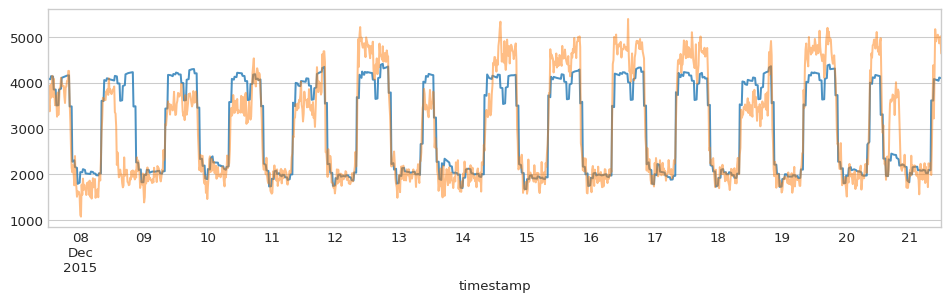

In [35]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    pred['consumption'][:1344].plot(ax=ax, alpha=0.8) #2 weeks data
    y[:1344].plot(ax=ax, alpha=0.5)

## Grouped linear regression model

The `feature_encoders.models.GroupedPredictor` can be applied on different clusters of a dataset. For this example, we assume that the clusters are created by a KMeans approach that is applied on daily consumption profiles, but there are smarter methods to distinguish between consumption profiles while ensuring that they are reliable during prediction (when no consumption data is available - see for instance how the [eensight](https://github.com/hebes-io/eensight) tool for automated M&V approaches this problem).      

Since each of the models in the ensemble predicts on a different subset of the input data (an observation cannot belong to more than one clusters), the final prediction is generated by vertically concatenating all the individual models’ predictions.
 
<img src="images/grouped.png" width="600">

In [36]:
data['time'] = data.index.time
data['date'] = data.index.date

to_cluster = data.pivot(index='date', columns='time', values='consumption')
to_cluster = to_cluster.fillna(method='bfill').fillna(method='ffill')

In [37]:
kmeans = KMeans(n_clusters=3).fit(to_cluster.values)
groups = pd.Series(data=kmeans.labels_, index=to_cluster.index)
data['group'] = data['date'].map(lambda x: str(groups[x]))

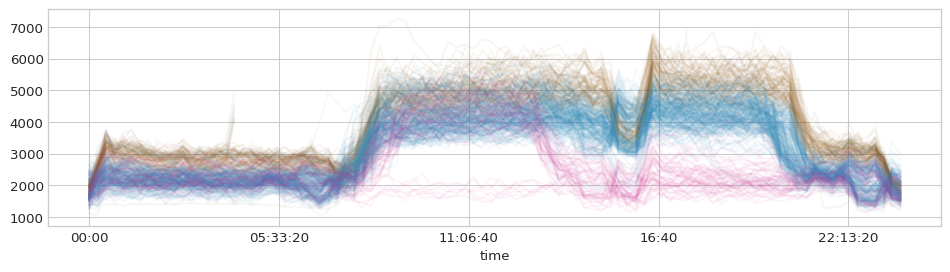

In [38]:
colors = ['#8c510a', '#3690c0', '#dd3497']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    for i, (_, grouped) in enumerate(data.groupby('group')):
        grouped.pivot(index='time', columns='date', values='consumption').plot(
            ax=ax, legend=False, alpha=0.05, color=colors[i])

In [39]:
X = data[['temperature', 'group']]
y = data['consumption']

In [40]:
model = GroupedPredictor(
            group_feature='group', 
            model_conf=model_conf, 
            feature_conf=feature_conf
)

In [41]:
%%time
model = model.fit(X, y)

Wall time: 2.83 s


The `GroupedPredictor` applies the feature generation transformers defined in `model_conf` directly on the dataset before it is split per cluster:

In [42]:
model.added_features_

[DatetimeFeatures(subset=['month', 'hourofweek'])]

... whereas the cluster predictors do not see or apply any feature generator:

In [43]:
for group, est in model.estimators_.items():
    print(group, '-->', est.composer_.added_features_)

0 --> []
1 --> []
2 --> []


In addition, `GroupedPredictor` fits all categorical encoders in ordinal form, and then passes the encoded data to each cluster predictor:

In [44]:
for name, encoder in model.encoders_['main_effects'].items():
    print(name, '-->', encoder)

month --> CategoricalEncoder(encode_as='ordinal', feature='month')
tow --> CategoricalEncoder(encode_as='ordinal', feature='hourofweek',
                   max_n_categories=60)


... and adds the `cluster` feature in every `stratify_by` that is not empty:

In [45]:
for pair_name, encoder in model.encoders_['interactions'].items():
    print(pair_name, '-->', encoder)

('tow', 'flex_temperature') --> {'tow': CategoricalEncoder(encode_as='ordinal', feature='hourofweek',
                   max_n_categories=2, min_samples_leaf=15,
                   stratify_by=['group', 'temperature'])}


The cluster predictors get encoders that operate on data that has been transformed by the categorical encoders of the `GroupedPredictor`. In this way, categorical data is always encoded with full information (while numerical data is encoded at the cluster level):

In [46]:
for group, est in model.estimators_.items():
    print('group ', group)
    for name, encoder in est.composer_.encoders_['main_effects'].items():
        print(name, '-->', encoder)
    print('\n')

group  0
month --> CategoricalEncoder(feature='month__for__month')
tow --> CategoricalEncoder(feature='hourofweek__for__tow')
lin_temperature --> IdentityEncoder(feature='temperature')


group  1
month --> CategoricalEncoder(feature='month__for__month')
tow --> CategoricalEncoder(feature='hourofweek__for__tow')
lin_temperature --> IdentityEncoder(feature='temperature')


group  2
month --> CategoricalEncoder(feature='month__for__month')
tow --> CategoricalEncoder(feature='hourofweek__for__tow')
lin_temperature --> IdentityEncoder(feature='temperature')




In [47]:
for group, est in model.estimators_.items():
    print('group ', group)
    for name, encoder in est.composer_.encoders_['interactions'].items():
        print(name, '-->', encoder)
    print('\n')

group  0
('tow', 'flex_temperature') --> ICatSplineEncoder(encoder_cat=CategoricalEncoder(feature='hourofweek__for__tow:flex_temperature',
                                                 min_samples_leaf=15),
                  encoder_num=SplineEncoder(degree=1, feature='temperature'))


group  1
('tow', 'flex_temperature') --> ICatSplineEncoder(encoder_cat=CategoricalEncoder(feature='hourofweek__for__tow:flex_temperature',
                                                 min_samples_leaf=15),
                  encoder_num=SplineEncoder(degree=1, feature='temperature'))


group  2
('tow', 'flex_temperature') --> ICatSplineEncoder(encoder_cat=CategoricalEncoder(feature='hourofweek__for__tow:flex_temperature',
                                                 min_samples_leaf=15),
                  encoder_num=SplineEncoder(degree=1, feature='temperature'))




In [48]:
%%time
pred = model.predict(X)

print(f"In-sample CV(RMSE) (%): {cvrmse(y, pred['consumption'])*100}")
print(f"In-sample NMBE (%): {nmbe(y, pred['consumption'])*100}")

In-sample CV(RMSE) (%): 13.537423014233884
In-sample NMBE (%): 0.0001238626531768618
Wall time: 567 ms


The number of parameters is:

In [49]:
model.n_parameters

242

the degrees of freedom:

In [50]:
model.dof

230

Since we have fitted one `LinearPredictor` per cluster, it is still easy to decompose the prediction into components:

In [51]:
%%time
pred = model.predict(X, include_components=True)
pred.head()

Wall time: 650 ms


,consumption,lin_temperature,month,tow,tow:flex_temperature
timestamp,,,,,
2015-12-07 12:00:00,4323.340119,1439.591296,669.917419,535.061043,1678.770360
2015-12-07 12:15:00,4315.882619,1462.242208,669.917419,535.061043,1648.661948
2015-12-07 12:30:00,4308.425119,1484.893120,669.917419,535.061043,1618.553536
2015-12-07 12:45:00,4305.942539,1507.544032,669.917419,535.061043,1593.420044
2015-12-07 13:00:00,4398.279232,1530.194944,669.917419,629.880316,1568.286553


In [52]:
assert np.allclose(pred['consumption'],
            pred[[col for col in pred.columns if col != 'consumption']].sum(axis=1)
)

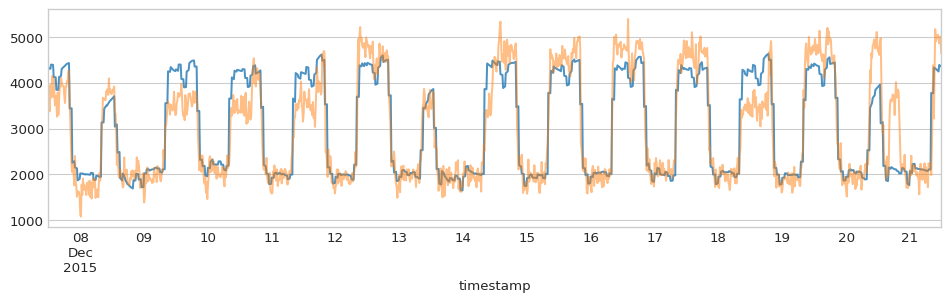

In [53]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    pred['consumption'][:1344].plot(ax=ax, alpha=0.8) #2 weeks data
    y[:1344].plot(ax=ax, alpha=0.5)

---------------